# Task 01: Introduction to Pytorch

## Introduction

The goal of this task is to get us thinking not just about training models, but about our *training pipelines*.

A neural network is a function, $f$, that accepts in data inputs, $\boldsymbol{X}$, and weights, $\boldsymbol{\Theta}$ that produces labels $\boldsymbol{\hat{y}}$,

$$
\boldsymbol{\hat{y}} = f(\Theta; \boldsymbol{X}).
$$

Meanwhile, a neural network training process, is itself a function, $g$, which accepts as input a dataset $x$, and for supervised algorithms a set of targets $y$, along with a set of parameters $\boldsymbol{\Omega}$ which define how the process is performed, and produces as output the weights of a neural network, $\boldsymbol{\Theta}$,

$$
\Theta = g(\boldsymbol{\Omega}; \boldsymbol{X}, \boldsymbol{y}).
$$

It is helpful to think of the training function, $g$, as a pipeline, composed of several training steps, which can include preprocessing, post processing, etc.

$$
g = g_N \circ\ \cdots\ \circ g_1.
$$

For example, $g_1$ might be a preprocessing step, then $g_2$ might be a training step, and $g_3$ might be a pruning step in a basic pipeline where data $(\boldsymbol{X}, \boldsymbol{y})$ goes in and weights $\boldsymbol{\Theta}$ come out.

We will learn to think of the training process this way by modifying some example code for a basic MNIST classification task. We begin with some imports.

In [1]:
%load_ext autoreload
%autoreload 2 
%matplotlib widget

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from dataclasses import dataclass 


## Task 01 - Part 1

Your first task is to:

* Add layer definitions to the following neural network class
* Define the forward pass

You can find starting architectures online. It is important to know there is no known theory to identify a best architecture *before* starting the problem. Trial and error (by iterative training and testing) is the only way to prove or disprove the utility of an architecture.

That said, recall some intuition about the way linear and nonlinear transforms work. We know we need a chain of both to have any hope of solving this problem. We also know that we need some depth, and cannot solve this problem by width alone.


In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Define convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # input channel = 1 (grayscale), output channels = 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) # input channels = 32, output channels = 64
        
        # Max-pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling by a factor of 2
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Assuming input image size is 28x28 (like MNIST)
        self.fc2 = nn.Linear(128, 10)          # 10 output classes (for classification)

        # Dropout layer (to avoid overfitting)
        self.dropout = nn.Dropout(0.25)
        raise NotImplementedError("Not implemented!")


    def forward(self, x):
        # Convolutional layers with ReLU and max pooling
        x = F.relu(self.conv1(x))  # Apply ReLU to conv1
        x = self.pool(F.relu(self.conv2(x)))  # Apply ReLU and pool after conv2
        
        # Flatten the tensor before feeding into fully connected layers
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch dimension
        
        # Fully connected layers
        x = F.relu(self.fc1(x))  # Apply ReLU to first fully connected layer
        x = self.dropout(x)      # Apply dropout
        x = self.fc2(x)          # No activation for the output layer (raw logits)
        
        # Output will be raw scores (logits) for each class, which will be processed by nll_loss (negative log likelihood loss)
        return F.log_softmax(x, dim=1)  # Apply log softmax to get probabilities for each class
        raise NotImplementedError("Not implemented!")



def run_training_epoch(
    training_params, model, device, train_loader, optimizer, epoch
):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % training_params.log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
            if training_params.dry_run:
                break


def predict(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

## Helper Code: Training Pipeline

For this assignment, the training pipeline is defined for you. Notice the similarities to the mathematical description of a trainer we saw above.

In [3]:
@dataclass
class TrainingParameters:
    """Training parameters for a simple neural network trainer."""

    batch_size: int = 64
    test_batch_size: int = 1000
    epochs: int = 14
    lr: float = 1.0
    gamma: float = 0.7
    normalizer_mean = 0.1307
    normalizer_std = 0.3081
    no_cuda: bool = True  # Enable or disable CUDA
    no_mps: bool = True  # Enable or disable GPU on MacOS
    dry_run: bool = False
    seed: int = 1
    log_interval: int = 10
    save_model: bool = True


def configure_training_device(training_params):
    use_cuda = not training_params.no_cuda and torch.cuda.is_available()
    use_mps = not training_params.no_mps and torch.backends.mps.is_available()

    torch.manual_seed(training_params.seed)

    if use_cuda:
        device = torch.device("cuda")
    elif use_mps:
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    train_kwargs = {"batch_size": training_params.batch_size}
    test_kwargs = {"batch_size": training_params.test_batch_size}

    if use_cuda:
        cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    return device, train_kwargs, test_kwargs


def build_preprocessing_transform(training_params):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                (training_params.normalizer_mean,),
                (training_params.normalizer_std,),
            ),
        ]
    )

    return transform


def build_data_loaders(train_kwargs, test_kwargs, transform):
    dataset1 = datasets.MNIST(
        "../data", train=True, download=True, transform=transform
    )
    dataset2 = datasets.MNIST("../data", train=False, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    return train_loader, test_loader


def train(training_params, device, train_loader, test_loader):
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=training_params.lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=training_params.gamma)

    for epoch in range(1, training_params.epochs + 1):
        run_training_epoch(
            training_params, model, device, train_loader, optimizer, epoch
        )
        predict(model, device, test_loader)
        scheduler.step()

        if training_params.save_model:
            torch.save(model.state_dict(), "mnist_cnn.pt")

## Example: Execute a Training Pipeline

With our training steps defined in modular fashion, we can easily define and execute a training pipeline.

In [4]:
def execute_training_pipeline():
    training_params = TrainingParameters(epochs=1, dry_run=True)
    device, train_kwargs, test_kwargs = configure_training_device(
        training_params
    )
    transform = build_preprocessing_transform(training_params)
    train_loader, test_loader = build_data_loaders(
        train_kwargs, test_kwargs, transform
    )
    train(training_params, device, train_loader, test_loader)


execute_training_pipeline()

NotImplementedError: Not implemented!

# Task 01 - Part 2: Explore Width

Using the example above, define a network with a single hidden layer.

Modify the trainer to store the train and test errors in a numpy vector.

Create a for loop over to iterate through a few different amounts of hidden neurons and train until convergence (when the error stops decreasing) each time.

Save the minimum error achieved and plot it with respect to the number of hidden nodes.

(It should be hard to get good convergence here - this is part of the exercise.)

Training with hidden size: 10
Converged at epoch 3 for hidden size 10.
Training with hidden size: 20
Converged at epoch 5 for hidden size 20.
Training with hidden size: 50
Converged at epoch 4 for hidden size 50.
Training with hidden size: 100
Converged at epoch 2 for hidden size 100.
Training with hidden size: 200
Converged at epoch 2 for hidden size 200.


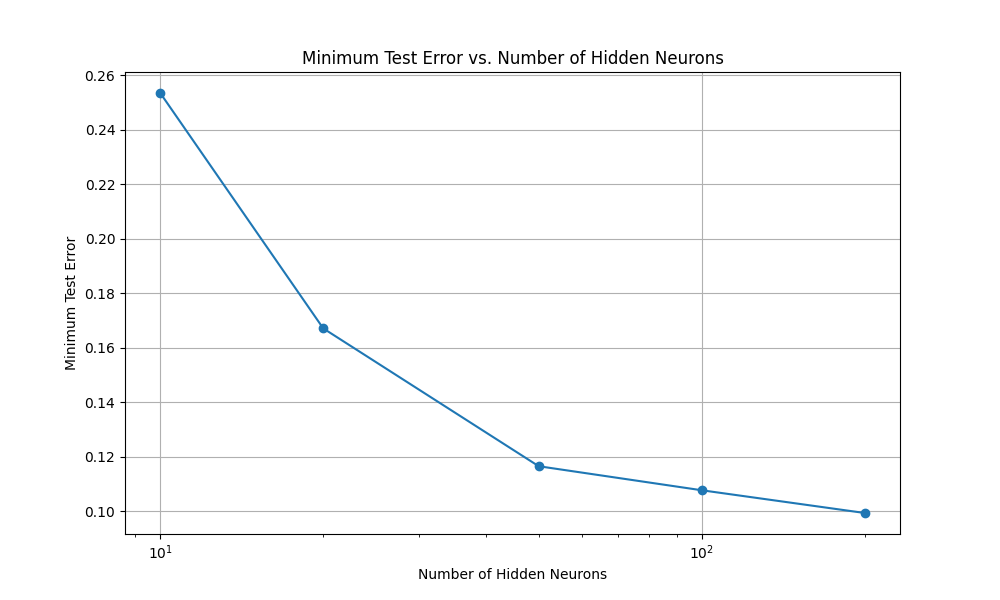

Task 01 - Part 3: Explore Depth

Now using the example above, define several networks with increasing numbers of hidden layers (either convolutional or fully connected).

As above, create a for loop over to iterate through a few different depths and train until convergence (when the error stops decreasing) each time.

Save the minimum error achieved and plot it with respect to the number of hidden nodes.

This example should converge much better.

Training with depth: 1 layers
Converged at epoch 3 for depth 1.
Training with depth: 2 layers
Converged at epoch 2 for depth 2.
Training with depth: 3 layers
Converged at epoch 4 for depth 3.
Training with depth: 4 layers
Converged at epoch 2 for depth 4.
Training with depth: 5 layers
Converged at epoch 3 for depth 5.


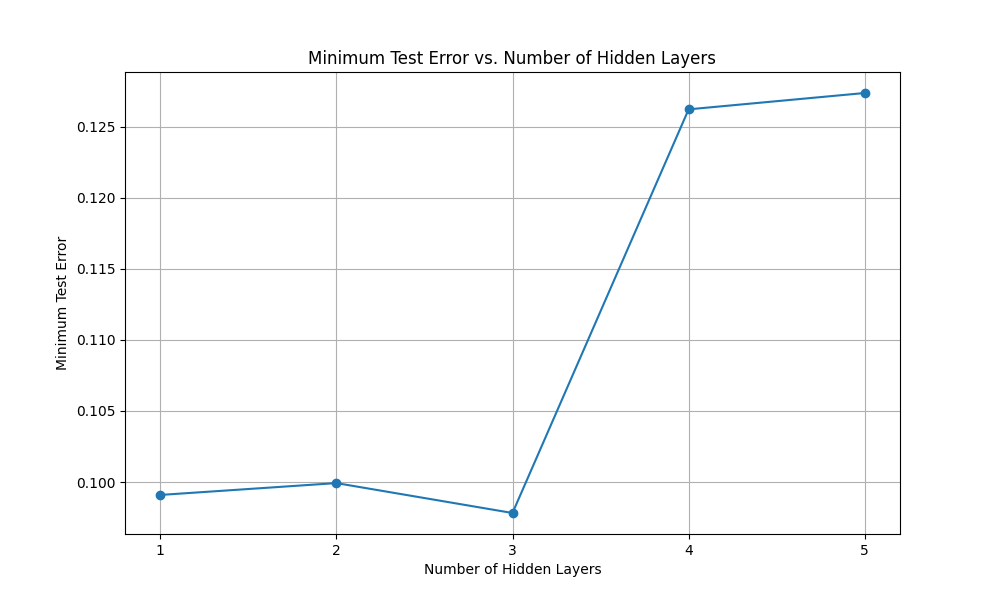